# Classifying Persian Tweets Emotion Using CNN-LSTM Model

**Table of contents**<a id='toc0_'></a>    
- [Import Libraries](#toc1_)    
- [Loading and Preparing Data](#toc2_)    
- [Visualizing Data Count](#toc3_)    
- [Preprocessing](#toc4_)    
  - [Checking Each Step](#toc4_1_)    
    - [Removing All HTML and URLS](#toc4_1_1_)    
    - [Removing Repetitive Characters in A Word](#toc4_1_2_)    
    - [Removing Stopwords](#toc4_1_3_)    
    - [Replacing Emojis with Their Textual Equivalents](#toc4_1_4_)    
    - [Spell Correction](#toc4_1_5_)    
    - [Stemming](#toc4_1_6_)    
  - [Wrap Up](#toc4_2_)    
  - [Saving the Preprocessed Data](#toc4_3_)    
  - [Loading the Preprocessed Data](#toc4_4_)    
- [Configuration](#toc5_)    
  - [Labels Extraction and Management](#toc5_1_)    
- [Feature Representation](#toc6_)    
  - [Tokenizing Using ParsBERT](#toc6_1_)    
    - [Tokenizing A Sample Tweet](#toc6_1_1_)    
    - [Tokenizing All Tweets](#toc6_1_2_)    
    - [Converting Tokens to Numerical Ids with Padding](#toc6_1_3_)    
  - [Embedding Using ParsBERT](#toc6_2_)    
    - [Default Embedding Vector Size](#toc6_2_1_)    
    - [Loading the Model and Adjusting the Embedding Vector Size](#toc6_2_2_)    
- [Splitting into Train, Validation, and Test](#toc7_)    
- [Models Architecture](#toc8_)    
  - [CNN-LSTM](#toc8_1_)    
  - [CNN](#toc8_2_)    
  - [LSTM](#toc8_3_)    
- [Greed Search for Hyperparameters Tunning](#toc9_)    
- [Training All Models](#toc10_)    
  - [CNN-LSTM](#toc10_1_)    
  - [CNN](#toc10_2_)    
  - [LSTM](#toc10_3_)    
  - [Learning Curve Visualization](#toc10_4_)    
    - [CNN-LSTM](#toc10_4_1_)    
    - [CNN](#toc10_4_2_)    
    - [LSTM](#toc10_4_3_)    
- [Evaluation](#toc11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Import Libraries](#toc0_)

In [86]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from farsi_tools import stop_words
import emoji
from hazm import Stemmer
from parsivar import SpellCheck
from transformers import AutoConfig, AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import gc
from sklearn.model_selection import train_test_split
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tabulate import tabulate

In [2]:
DATA_PATH='Q1-Data/'
PREPROC_DATA_PATH='preprocessed_tweets.csv'

# <a id='toc2_'></a>[Loading and Preparing Data](#toc0_)

In [3]:
dataframes = []

for filename in os.listdir(DATA_PATH):
    if filename.endswith('.csv'):
        dataframe = pd.read_csv(os.path.join(DATA_PATH, filename))
        
        dataframe = dataframe[['tweet']].copy()
        dataframe['emotion'] = filename[:-4]
        
        dataframes.append(dataframe)

combined_df = pd.concat(dataframes, ignore_index=True)

In [4]:
combined_df

,tweet,emotion
0,ــــــــــــ\nكرمهاي ساقه خوار\nبه جان ريشههاي...,joy
1,كرمهاي ساقه خوار\nبه جان ريشههاي انقلاب و نظام...,joy
2,انتخابات، واجبی هست\nکه اگر غفلت شود فرصتی برا...,joy
3,ــــــــــــ👌🤞\nكرمهاي ساقه خوار\nبه جان ريشهه...,joy
4,كرمهاي ساقه خوار\nبه جان ريشههاي انقلاب و نظام...,joy
...,...,...
113824,پرخاشگری پلیس #افغانستان؛ نیروی غیرحرفه‌ای یا ...,anger
113825,فروید می‌گوید: «تمدن از آنجا آغاز شد که انسان ...,anger
113826,#رشتو\n۱) صبح امروز(۰۰/۰۱/۱۵) راننده خطی ایستگ...,anger
113827,وقتی میگیم #پالانفارسیسم ملقمه بیشعوری فروما...,anger


# <a id='toc3_'></a>[Visualizing Data Count](#toc0_)

/tmp/ipykernel_9799/163428217.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='emotion', data=combined_df, palette="pastel")


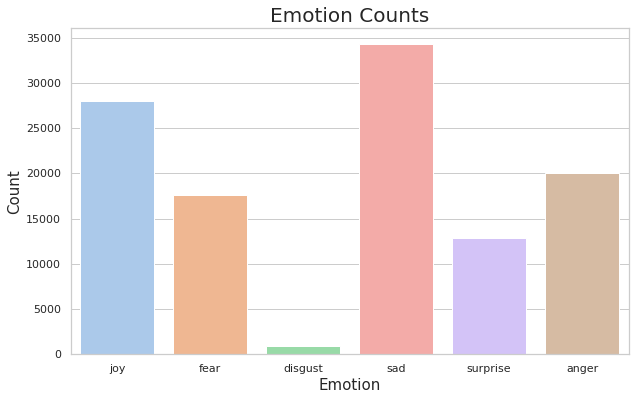

In [5]:
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
ax = sns.countplot(x='emotion', data=combined_df, palette="pastel")

plt.title('Emotion Counts', fontsize=20)
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.show()

# <a id='toc4_'></a>[Preprocessing](#toc0_)

## <a id='toc4_1_'></a>[Checking Each Step](#toc0_)

In [6]:
sample_tweet = 'برای تمرین بیشتر برنامه‌نیوسی به صورت پروژه‌محور می‌توانید به این لینک (https://github.com/) مراجعه کنید. اینجا می‌تووونیددد پروژه‌های خودتوووون رو بذارین و مال بقیه رو هم ببینید 🎉🌟🔥'

In [7]:
sample_tweet

'برای تمرین بیشتر برنامه\u200cنیوسی به صورت پروژه\u200cمحور می\u200cتوانید به این لینک (https://github.com/) مراجعه کنید. اینجا می\u200cتووونیددد پروژه\u200cهای خودتوووون رو بذارین و مال بقیه رو هم ببینید 🎉🌟🔥'

### <a id='toc4_1_1_'></a>[Removing All HTML and URLS](#toc0_)

In [8]:
cleaned_tweet = re.sub(r'<[^<>]*>', '', sample_tweet)

cleaned_tweet = re.sub(r'http\S+', '', cleaned_tweet)

print(f"Original tweet\n: {sample_tweet}")
print(f"\nCleaned tweet\n: {cleaned_tweet}")

Original tweet
: برای تمرین بیشتر برنامه‌نیوسی به صورت پروژه‌محور می‌توانید به این لینک (https://github.com/) مراجعه کنید. اینجا می‌تووونیددد پروژه‌های خودتوووون رو بذارین و مال بقیه رو هم ببینید 🎉🌟🔥

Cleaned tweet
: برای تمرین بیشتر برنامه‌نیوسی به صورت پروژه‌محور می‌توانید به این لینک ( مراجعه کنید. اینجا می‌تووونیددد پروژه‌های خودتوووون رو بذارین و مال بقیه رو هم ببینید 🎉🌟🔥


### <a id='toc4_1_2_'></a>[Removing Repetitive Characters in A Word](#toc0_)

In [9]:
def remove_repetitive_characters(tweet):
    words = tweet.split()

    cleaned_words = []

    for word in words:
        cleaned_word = re.sub(r'(.)\1+', r'\1', word)
        cleaned_words.append(cleaned_word)

    cleaned_tweet = ' '.join(cleaned_words)
    return cleaned_tweet


cleaned_tweet = remove_repetitive_characters(sample_tweet)

print(f"Original tweet\n: {sample_tweet}")
print(f"\nCleaned tweet\n: {cleaned_tweet}")

Original tweet
: برای تمرین بیشتر برنامه‌نیوسی به صورت پروژه‌محور می‌توانید به این لینک (https://github.com/) مراجعه کنید. اینجا می‌تووونیددد پروژه‌های خودتوووون رو بذارین و مال بقیه رو هم ببینید 🎉🌟🔥

Cleaned tweet
: برای تمرین بیشتر برنامه‌نیوسی به صورت پروژه‌محور می‌توانید به این لینک (htps:/github.com/) مراجعه کنید. اینجا می‌تونید پروژه‌های خودتون رو بذارین و مال بقیه رو هم بینید 🎉🌟🔥


### <a id='toc4_1_3_'></a>[Removing Stopwords](#toc0_)

In [10]:
persian_sw = stop_words()

In [11]:
persian_sw

['!',
 '"',
 '#',
 ',',
 '-',
 '/',
 ':',
 '«',
 '»',
 '،',
 '؛',
 '؟',
 '۰',
 '۱',
 '۲',
 '۳',
 '۴',
 '۵',
 '۶',
 '۷',
 '۸',
 '۹',
 '…',
 '$',
 '!',
 ',',
 ':',
 ';',
 '،',
 '؛',
 '؟',
 'آباد',
 'آره',
 'آری',
 'آمد',
 'آمده',
 'آن',
 'آنان',
 'آنجا',
 'آنطور',
 'آنقدر',
 'آنکه',
 'آنها',
 'آنچه',
 'آنکه',
 'آورد',
 'آورده',
 'آید',
 'آی',
 'آیا',
 'آیند',
 'اتفاقا',
 'اثر',
 'احتراما',
 'احتمالا',
 'اخیر',
 'اری',
 'از',
 'ازجمله',
 'اساسا',
 'است',
 'استفاد',
 'استفاده',
 'اش',
 'اشکارا',
 'اصلا',
 'اصولا',
 'اعلام',
 'اغلب',
 'اکنون',
 'الان',
 'البته',
 'البتّه',
 'ام',
 'اما',
 'امروز',
 'امروزه',
 'امسال',
 'امشب',
 'امور',
 'ان',
 'انجام',
 'اند',
 'انشاالله',
 'انصافا',
 'انطور',
 'انقدر',
 'انها',
 'انچنان',
 'انکه',
 'انگار',
 'او',
 'اول',
 'اولا',
 'ای',
 'ایشان',
 'ایم',
 'این',
 'اینکه',
 'اکثرا',
 'اکنون',
 'اگر',
 'ای',
 'ایا',
 'اید',
 'ایشان',
 'ایم',
 'این',
 'اینجا',
 'ایند',
 'اینطور',
 'اینقدر',
 'اینها',
 'اینچنین',
 'اینک',
 'اینکه',
 'اینگونه',
 'با',
 'بار',


In [12]:
filtered_words = [word for word in sample_tweet.split() if word not in persian_sw]


cleaned_tweet = ' '.join(filtered_words)

print(f"Original tweet:\n {sample_tweet}")
print(f"\nCleaned tweet (without Persian stopwords):\n {cleaned_tweet}")

Original tweet:
 برای تمرین بیشتر برنامه‌نیوسی به صورت پروژه‌محور می‌توانید به این لینک (https://github.com/) مراجعه کنید. اینجا می‌تووونیددد پروژه‌های خودتوووون رو بذارین و مال بقیه رو هم ببینید 🎉🌟🔥

Cleaned tweet (without Persian stopwords):
 تمرین برنامه‌نیوسی پروژه‌محور می‌توانید لینک (https://github.com/) مراجعه کنید. می‌تووونیددد پروژه‌های خودتوووون بذارین مال بقیه ببینید 🎉🌟🔥


### <a id='toc4_1_4_'></a>[Replacing Emojis with Their Textual Equivalents](#toc0_)

In [13]:
def demojizer(text):

    demojized_tweet = emoji.demojize(text, language='fa')
    demojized_tweet = re.sub(r":(\w+):", r" \1 ", demojized_tweet)
    demojized_tweet = demojized_tweet.split()

    for ind, word in enumerate(demojized_tweet):
        if '_' in word:
            word = word.replace('_', ' ')
            demojized_tweet[ind] = word

    return ' '.join(demojized_tweet)

In [14]:
demojized_tweet = demojizer(sample_tweet)

In [15]:
print(f"Original tweet:\n {sample_tweet}")
print(f"\nDemojized tweet:\n {demojized_tweet}")

Original tweet:
 برای تمرین بیشتر برنامه‌نیوسی به صورت پروژه‌محور می‌توانید به این لینک (https://github.com/) مراجعه کنید. اینجا می‌تووونیددد پروژه‌های خودتوووون رو بذارین و مال بقیه رو هم ببینید 🎉🌟🔥

Demojized tweet:
 برای تمرین بیشتر برنامه‌نیوسی به صورت پروژه‌محور می‌توانید به این لینک (https://github.com/) مراجعه کنید. اینجا می‌تووونیددد پروژه‌های خودتوووون رو بذارین و مال بقیه رو هم ببینید بمب کاغذ رنگی ستاره درخشان آتش


### <a id='toc4_1_5_'></a>[Spell Correction](#toc0_)

In [16]:
spell_checker = SpellCheck()

In [17]:
corrected_text = spell_checker.spell_corrector(sample_tweet)

In [18]:
print(f"Original tweet:\n {sample_tweet}")
print(f"\nSpell corrected tweet:\n {corrected_text}")

Original tweet:
 برای تمرین بیشتر برنامه‌نیوسی به صورت پروژه‌محور می‌توانید به این لینک (https://github.com/) مراجعه کنید. اینجا می‌تووونیددد پروژه‌های خودتوووون رو بذارین و مال بقیه رو هم ببینید 🎉🌟🔥

Spell corrected tweet:
 برای تمرین بیشتر برنامه‌نویسی به صورت پروژه محور می‌توانید به این لینک ( https :// github . com / ) مراجعه کنید . این جا می‌تووونیددد پروژه‌های خودتوووون رو بزارین و سال بقیه را هم ببینید


### <a id='toc4_1_6_'></a>[Stemming](#toc0_)

In [19]:
stemmer = Stemmer()

In [20]:
def apply_stemming(text):
    words = text.split()
    stemmed_words = []
    
    for word in words:
        stemmed_word = stemmer.stem(word)
        stemmed_words.append(stemmed_word)
    
    return ' '.join(stemmed_words)

In [21]:
stemmed_tweet = apply_stemming(sample_tweet)

In [22]:
print(f"Original tweet:\n {sample_tweet}")
print(f"\nStemmed tweet:\n {stemmed_tweet}")

Original tweet:
 برای تمرین بیشتر برنامه‌نیوسی به صورت پروژه‌محور می‌توانید به این لینک (https://github.com/) مراجعه کنید. اینجا می‌تووونیددد پروژه‌های خودتوووون رو بذارین و مال بقیه رو هم ببینید 🎉🌟🔥

Stemmed tweet:
 برا تمرین ب برنامه‌نیوس به صور پروژه‌محور می‌توانید به این لینک (https://github.com/) مراجعه کنید. اینجا می‌تووونیددد پروژه خودتوووون رو بذارین و مال بقیه رو ه ببینید 🎉🌟🔥


## <a id='toc4_2_'></a>[Wrap Up](#toc0_)

In [23]:
class Preprocessor:
    def __init__(self, stemmer, spell_checker, stop_words):
        self.stemmer = stemmer
        self.spell_checker = spell_checker
        self.persian_sw = stop_words

    def remove_html_and_urls(self, tweet):
        cleaned_tweet = re.sub(r'<[^<>]*>', '', tweet)
        cleaned_tweet = re.sub(r'http\S+', '', cleaned_tweet)

        return cleaned_tweet

    def remove_repetitive_characters(self, tweet):
        words = tweet.split()
        cleaned_words = [re.sub(r'(.)\1+', r'\1', word) for word in words]

        return ' '.join(cleaned_words)

    def remove_stopwords(self, tweet):
        words = tweet.split()
        filtered_words = [word for word in words if word not in self.persian_sw]

        return ' '.join(filtered_words)

    def demojizer(self, text):
        demojized_tweet = emoji.demojize(text, language='fa')
        demojized_tweet = re.sub(r":(\w+):", r" \1 ", demojized_tweet)
        demojized_tweet = demojized_tweet.split()

        for ind, word in enumerate(demojized_tweet):
            if '_' in word:
                word = word.replace('_', ' ')
                demojized_tweet[ind] = word

        return ' '.join(demojized_tweet)

    def correct_spellings(self, tweet):
        return self.spell_checker.spell_corrector(tweet)

    def apply_stemming(self, text):
        words = text.split()
        stemmed_words = [self.stemmer.stem(word) for word in words]

        return ' '.join(stemmed_words)

    def preprocess(self, tweet):
        tweet = self.remove_html_and_urls(tweet)
        tweet = self.remove_repetitive_characters(tweet)
        tweet = self.remove_stopwords(tweet)
        tweet = self.demojizer(tweet)
        tweet = self.correct_spellings(tweet)
        tweet = self.apply_stemming(tweet)

        return tweet


In [24]:
if not os.path.exists(PREPROC_DATA_PATH):
    preprocessor = Preprocessor(stemmer, spell_checker, persian_sw)
    combined_df['preprocessed_tweet'] = combined_df['tweet'].apply(preprocessor.preprocess)
else:
    print('Preprocessing have already done!')

Preprocessing have already done!


In [25]:
combined_df

,tweet,emotion
0,ــــــــــــ\nكرمهاي ساقه خوار\nبه جان ريشههاي...,joy
1,كرمهاي ساقه خوار\nبه جان ريشههاي انقلاب و نظام...,joy
2,انتخابات، واجبی هست\nکه اگر غفلت شود فرصتی برا...,joy
3,ــــــــــــ👌🤞\nكرمهاي ساقه خوار\nبه جان ريشهه...,joy
4,كرمهاي ساقه خوار\nبه جان ريشههاي انقلاب و نظام...,joy
...,...,...
113824,پرخاشگری پلیس #افغانستان؛ نیروی غیرحرفه‌ای یا ...,anger
113825,فروید می‌گوید: «تمدن از آنجا آغاز شد که انسان ...,anger
113826,#رشتو\n۱) صبح امروز(۰۰/۰۱/۱۵) راننده خطی ایستگ...,anger
113827,وقتی میگیم #پالانفارسیسم ملقمه بیشعوری فروما...,anger


## <a id='toc4_3_'></a>[Saving the Preprocessed Data](#toc0_)

In [26]:
if not os.path.exists(PREPROC_DATA_PATH):
    preprocessed_df = combined_df[['preprocessed_tweet', 'emotion']]
    preprocessed_df.to_csv('preprocessed_tweets.csv', index=False)
else:
    print('Preprocessing have already done!')

Preprocessing have already done!


## <a id='toc4_4_'></a>[Loading the Preprocessed Data](#toc0_)

In [27]:
preprocessed_data = pd.read_csv('preprocessed_tweets.csv')
preprocessed_data

,preprocessed_tweet,emotion
0,کرم ساقه خوار ج ریش انقلاب نظا آسمان افتاده ان...,joy
1,کرم ساقه خوار ج ریش انقلاب نظا آسمان افتاده ان...,joy
2,انتخاب ، واجب غفل فرصت با قض نیس . مسئول ، و ب...,joy
3,سلام او ک انگ گره خورده کرم ساقه خوار ج ریش ان...,joy
4,کرم ساقه خوار ج ریش انقلاب نظا آسمان افتاده ان...,joy
...,...,...
113824,پرخاشگر پلیس # افغانس ؛ نیرو غیر حرفه گرگ تن ؟...,anger
113825,فروید می‌گوید : « تمدن آغاز انس سنگ ، کلمه پرت...,anger
113826,# ر و 1 ) صبح امروز ( 0 / 01 / 15 ) را نده خط ...,anger
113827,م گ # پالانفارسیس ملغمه بیشعور فرومایگ شرف س پ...,anger


In [28]:
if not os.path.exists(PREPROC_DATA_PATH):
    preprocessed_df
else:
    print('Preprocessing have already done!')

Preprocessing have already done!


# <a id='toc5_'></a>[Configuration](#toc0_)

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [30]:
device = "cpu"

## <a id='toc5_1_'></a>[Labels Extraction and Management](#toc0_)

In [31]:
labels = preprocessed_data['emotion'].unique()
labels

array(['joy', 'fear', 'disgust', 'sad', 'surprise', 'anger'], dtype=object)

In [32]:
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'joy': 0, 'fear': 1, 'disgust': 2, 'sad': 3, 'surprise': 4, 'anger': 5}
id2label: {0: 'joy', 1: 'fear', 2: 'disgust', 3: 'sad', 4: 'surprise', 5: 'anger'}


# <a id='toc6_'></a>[Feature Representation](#toc0_)

## <a id='toc6_1_'></a>[Tokenizing Using ParsBERT](#toc0_)

### <a id='toc6_1_1_'></a>[Tokenizing A Sample Tweet](#toc0_)

In [33]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

sample_tweet = preprocessed_data['preprocessed_tweet'].iloc[0]
tokens = tokenizer.tokenize(sample_tweet)

print(tokens)

/home/javad/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['کرم', 'ساقه', 'خوار', 'ج', 'ریش', 'انقلاب', 'نظ', '##ا', 'اسمان', 'افتاده', 'اند', '؛', 'حضور', 'سبز', 'گام', 'استوار', 'انتخاب', '،', 'جشن', 'دفع', 'اف', 'استکبار', 'اس', '.', '[UNK]', 'مرد', 'مید', '[UNK]', 'را', 'میده']


### <a id='toc6_1_2_'></a>[Tokenizing All Tweets](#toc0_)

In [34]:
preprocessed_data['tokenized_tweet'] = preprocessed_data['preprocessed_tweet'].apply(lambda x: tokenizer.tokenize(x))

### <a id='toc6_1_3_'></a>[Converting Tokens to Numerical Ids with Padding](#toc0_)

In [35]:
max_length = 32

In [36]:
def tokenize_tweets(df, col, tokenizer, max_length=max_length):
    tokens = tokenizer.batch_encode_plus(
        df[col].tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    return tokens

In [37]:
tokens = tokenize_tweets(df=preprocessed_data, col='preprocessed_tweet',
                         tokenizer=tokenizer, max_length=max_length)

In [38]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [39]:
tokens['input_ids']

tensor([[    2, 10000, 20709,  ...,  2049,  2422,     4],
        [    2, 10000, 20709,  ...,  2049,  2422,     4],
        [    2,  2431,   300,  ...,  2431,     1,     4],
        ...,
        [    2,     1,   315,  ...,  2603,  7252,     4],
        [    2,   328,   373,  ..., 80228,  2285,     4],
        [    2,  2687,  3700,  ..., 12520,  3080,     4]])

In [40]:
tokens['token_type_ids']

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [41]:
tokens['attention_mask']

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

## <a id='toc6_2_'></a>[Embedding Using ParsBERT](#toc0_)

### <a id='toc6_2_1_'></a>[Default Embedding Vector Size](#toc0_)

In [42]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

print(f"Default embedding vector size: {config.hidden_size}")

/home/javad/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Default embedding vector size: 768


### <a id='toc6_2_2_'></a>[Loading the Model and Adjusting the Embedding Vector Size](#toc0_)

In [43]:
config.hidden_size = 120

model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", config=config,
                                  ignore_mismatched_sizes=True)
model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized because the shapes did not match:
- bert.embeddings.word_embeddings.weight: found shape torch.Size([100000, 768]) in the checkpoint and torch.Size([100000, 120]) in the model instantiated
- bert.embeddings.position_embeddings.weight: found shape torch.Size([512, 768]) in the checkpoint and torch.Size([512, 120]) in the model instantiated
- bert.embeddings.token_type_embeddings.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([2, 120]) in the model instantiated
- bert.embeddings.LayerNorm.weight: found shape torch.Size([768]) in the checkpoint and torch.Size([120]) in the model instantiated
- bert.embeddings.LayerNorm.bias: found shape torch.Size([768]) in the checkpoint and torch.Size([120]) in the model instantiated
- bert.encoder.layer.0.attention.self.query.weight: found shape torch.Size([768, 768]) in the checkpoint a

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 120, padding_idx=0)
    (position_embeddings): Embedding(512, 120)
    (token_type_embeddings): Embedding(2, 120)
    (LayerNorm): LayerNorm((120,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=120, out_features=120, bias=True)
            (key): Linear(in_features=120, out_features=120, bias=True)
            (value): Linear(in_features=120, out_features=120, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=120, out_features=120, bias=True)
            (LayerNorm): LayerNorm((120,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [44]:
chunk_size = 1000

total_samples = len(preprocessed_data)

all_embeddings = []

In [45]:
for i in range(0, total_samples, chunk_size):
    chunk = preprocessed_data[i:i+chunk_size]

    tokens = tokenize_tweets(df=chunk, col='preprocessed_tweet', tokenizer=tokenizer, max_length=max_length)

    with torch.no_grad():
        outputs = model(tokens['input_ids'].to(device), attention_mask=tokens['attention_mask'].to(device))
        embeddings = outputs.last_hidden_state

    all_embeddings.append(embeddings)

    gc.collect()

In [46]:
all_embeddings = torch.cat(all_embeddings, dim=0)

all_embeddings

tensor([[[ 0.4971, -0.7276,  0.9489,  ..., -0.5860, -0.3827,  0.0680],
         [-0.7805,  0.4492,  0.4129,  ...,  1.3416,  0.2323,  0.3303],
         [-0.7817,  0.5793,  2.1158,  ...,  1.0192,  0.1531,  0.7978],
         ...,
         [ 0.5830, -0.8681,  0.7460,  ...,  0.4656, -1.7747,  0.6180],
         [ 1.0554, -0.6751,  0.7082,  ...,  1.4857,  0.4241, -1.1130],
         [ 0.4141, -1.3672,  0.4554,  ...,  1.3373, -0.5169, -1.7581]],

        [[ 0.4971, -0.7276,  0.9489,  ..., -0.5860, -0.3827,  0.0680],
         [-0.7805,  0.4492,  0.4129,  ...,  1.3416,  0.2323,  0.3303],
         [-0.7817,  0.5793,  2.1158,  ...,  1.0192,  0.1531,  0.7978],
         ...,
         [ 0.5830, -0.8681,  0.7460,  ...,  0.4656, -1.7747,  0.6180],
         [ 1.0554, -0.6751,  0.7082,  ...,  1.4857,  0.4241, -1.1130],
         [ 0.4141, -1.3672,  0.4554,  ...,  1.3373, -0.5169, -1.7581]],

        [[ 0.4662, -0.6685,  0.9515,  ..., -0.5917, -0.3810,  0.0845],
         [-1.2930, -0.8785, -0.0468,  ...,  0

In [47]:
all_embeddings.shape

torch.Size([113829, 32, 120])

# <a id='toc7_'></a>[Splitting into Train, Validation, and Test](#toc0_)

In [48]:
labels_num = preprocessed_data['emotion'].apply(lambda x: label2id[x])

X_train, X_test, y_train, y_test = train_test_split(all_embeddings, labels_num, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [60]:
y_train = torch.tensor(y_train.values)
y_val = torch.tensor(y_val.values)

# <a id='toc8_'></a>[Models Architecture](#toc0_)

## <a id='toc8_1_'></a>[CNN-LSTM](#toc0_)

In [49]:
class CNNTweetClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(CNNTweetClassifier, self).__init__()

        self.conv1 = nn.Conv1d(embedding_dim, 32, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(32, 32, batch_first=True)
        self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # swap dimensions to (batch_size, embedding_dim, sequence_length)
        x = self.conv1(x)
        x = self.maxpool(x)
        x, _ = self.lstm(x.permute(0, 2, 1))  # swap dimensions back to (batch_size, sequence_length, embedding_dim)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])  # use the last LSTM output for the Dense layer
        return x

In [50]:
# Instantiate the model
cnn_lstm_model = CNNTweetClassifier(embedding_dim=120, num_classes=len(label2id))

## <a id='toc8_2_'></a>[CNN](#toc0_)

In [78]:
class CNNTweetClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(CNNTweetClassifier, self).__init__()
        
        self.conv1 = nn.Conv1d(embedding_dim, 32, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(32*16, num_classes)  # Adjust the input size here
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # swap dimensions to (batch_size, embedding_dim, sequence_length)
        x = self.conv1(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.dropout(x)
        x = self.fc(x)  # No need to select the last output here
        return x


In [79]:
cnn_model = CNNTweetClassifier(embedding_dim=120, num_classes=len(label2id))

## <a id='toc8_3_'></a>[LSTM](#toc0_)

In [53]:
class LSTMTweetClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes):
        super(LSTMTweetClassifier, self).__init__()
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x, _ = self.lstm(x)  # LSTM input is (batch_size, sequence_length, embedding_dim)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])  # use the last LSTM output for the Dense layer
        return x

In [54]:
lstm_model = LSTMTweetClassifier(embedding_dim=120, hidden_dim=32, num_classes=len(label2id))

# <a id='toc9_'></a>[Greed Search for Hyperparameters Tunning](#toc0_)

In [57]:
batch_sizes = [8, 64]
learning_rates = [0.001, 0.0001]
optimizers = [Adam, SGD]
epochs = 10

best_val_acc = 0
best_hyperparams = {}

In [62]:
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for optimizer in optimizers:
            if optimizer == Adam:
                opt = Adam(model.parameters(), lr=learning_rate)
            elif optimizer == SGD:
                opt = SGD(model.parameters(), lr=learning_rate)

            loss_fn = CrossEntropyLoss()

            for epoch in range(epochs):
                for i in range(0, len(X_train), batch_size):
                    inputs = X_train[i:i+batch_size]
                    labels = y_train[i:i+batch_size]

                    outputs = cnn_lstm_model(inputs)
                    loss = loss_fn(outputs, labels)

                    opt.zero_grad()
                    loss.backward()
                    opt.step()

                val_preds, val_labels = [], []
                with torch.no_grad():
                    for i in range(0, len(X_val), batch_size):
                        inputs = X_val[i:i+batch_size]
                        labels = y_val[i:i+batch_size]
                        outputs = cnn_lstm_model(inputs)
                        _, preds = torch.max(outputs, 1)
                        val_preds.extend(preds.tolist())
                        val_labels.extend(labels.tolist())

                val_acc = accuracy_score(val_labels, val_preds)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_hyperparams = {'batch_size': batch_size, 'learning_rate': learning_rate, 'optimizer': optimizer}

In [66]:
def greed_search(model, epochs):
    best_val_acc = 0
    best_hyperparams = {}

    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for optimizer in optimizers:
                if optimizer == Adam:
                    opt = Adam(model.parameters(), lr=learning_rate)
                elif optimizer == SGD:
                    opt = SGD(model.parameters(), lr=learning_rate)

                loss_fn = CrossEntropyLoss()

                for epoch in range(epochs):
                    for i in range(0, len(X_train), batch_size):
                        inputs = X_train[i:i+batch_size]
                        labels = y_train[i:i+batch_size]

                        outputs = model(inputs)
                        loss = loss_fn(outputs, labels)

                        opt.zero_grad()
                        loss.backward()
                        opt.step()

                    val_preds, val_labels = [], []

                    with torch.no_grad():
                        for i in range(0, len(X_val), batch_size):
                            inputs = X_val[i:i+batch_size]
                            labels = y_val[i:i+batch_size]
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            val_preds.extend(preds.tolist())
                            val_labels.extend(labels.tolist())

                    val_acc = accuracy_score(val_labels, val_preds)

                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_hyperparams = {'batch_size': batch_size, 'learning_rate': learning_rate, 'optimizer': optimizer}
    
    return best_val_acc, best_hyperparams

In [67]:
best_val_acc, best_hyperparams = greed_search(cnn_lstm_model, epochs)

In [68]:
print(f'Best validation accuracy: {best_val_acc}')
print(f'Best hyperparameters: {best_hyperparams}')

Best validation accuracy: 0.6655371485943775
Best hyperparameters: {'batch_size': 64, 'learning_rate': 0.0001, 'optimizer': <class 'torch.optim.sgd.SGD'>}


# <a id='toc10_'></a>[Training All Models](#toc0_)

In [71]:
def train_model(model, X_train, y_train, X_val, y_val, best_hyperparams, epochs):

    opt = SGD(model.parameters(), lr=best_hyperparams['learning_rate'])

    loss_fn = CrossEntropyLoss()

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        # Training loop
        train_preds, train_labels = [], []
        for i in range(0, len(X_train), best_hyperparams['batch_size']):
            inputs = X_train[i:i+best_hyperparams['batch_size']]
            labels = y_train[i:i+best_hyperparams['batch_size']]

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            opt.zero_grad()
            loss.backward()
            opt.step()

            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.tolist())
            train_labels.extend(labels.tolist())

        # Calculate training loss and accuracy
        train_loss = loss.item()
        train_acc = accuracy_score(train_labels, train_preds)

        # Validation loop
        val_preds, val_labels = [], []
        with torch.no_grad():
            for i in range(0, len(X_val), best_hyperparams['batch_size']):
                inputs = X_val[i:i+best_hyperparams['batch_size']]
                labels = y_val[i:i+best_hyperparams['batch_size']]
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.tolist())
                val_labels.extend(labels.tolist())

        # Calculate validation loss and accuracy
        val_loss = loss.item()
        val_acc = accuracy_score(val_labels, val_preds)

        # Save loss and accuracy values
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    return train_losses, train_accuracies, val_losses, val_accuracies


## <a id='toc10_1_'></a>[CNN-LSTM](#toc0_)

In [72]:
cl_train_losses, cl_train_accuracies, cl_val_losses, cl_val_accuracies = train_model(cnn_lstm_model, X_train, y_train,
                                                                         X_val, y_val, best_hyperparams, epochs)

## <a id='toc10_2_'></a>[CNN](#toc0_)

In [80]:
c_train_losses, c_train_accuracies, c_val_losses, c_val_accuracies = train_model(cnn_model, X_train, y_train,
                                                                         X_val, y_val, best_hyperparams, epochs)

## <a id='toc10_3_'></a>[LSTM](#toc0_)

In [74]:
l_train_losses, l_train_accuracies, l_val_losses, l_val_accuracies = train_model(lstm_model, X_train, y_train,
                                                                         X_val, y_val, best_hyperparams, epochs)

In [75]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## <a id='toc10_4_'></a>[Learning Curve Visualization](#toc0_)

### <a id='toc10_4_1_'></a>[CNN-LSTM](#toc0_)

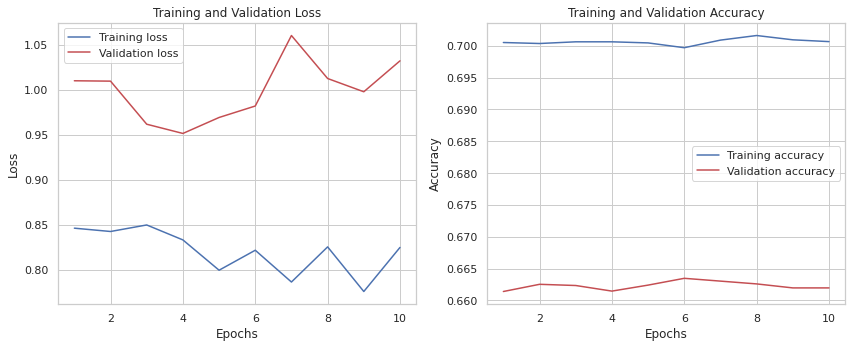

In [76]:
plot_metrics(cl_train_losses, cl_train_accuracies, cl_val_losses, cl_val_accuracies)

### <a id='toc10_4_2_'></a>[CNN](#toc0_)

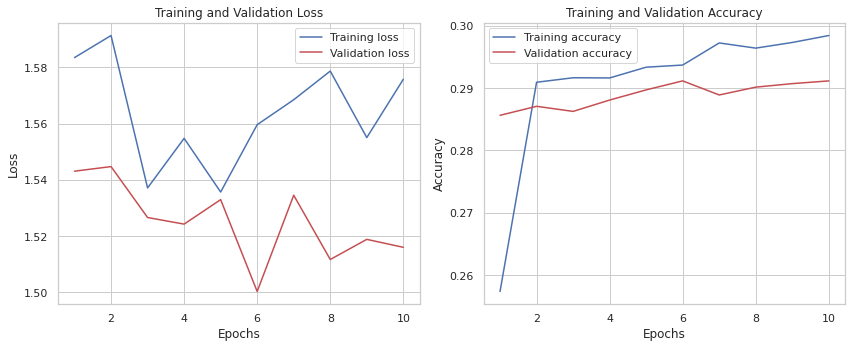

In [81]:
plot_metrics(c_train_losses, c_train_accuracies, c_val_losses, c_val_accuracies)

### <a id='toc10_4_3_'></a>[LSTM](#toc0_)

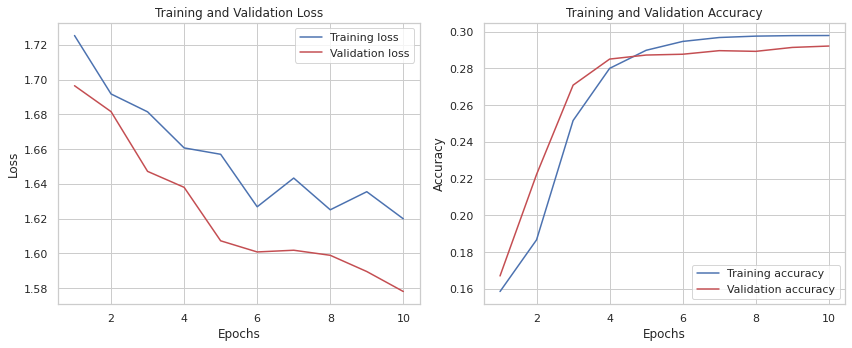

In [77]:
plot_metrics(l_train_losses, l_train_accuracies, l_val_losses, l_val_accuracies)

# <a id='toc11_'></a>[Evaluation](#toc0_)

In [82]:
def predict(model, X_test, batch_size):
    test_preds = []

    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs = X_test[i:i+batch_size]
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.tolist())

    return test_preds

In [87]:
def evaluate_model(model, X_test, y_test, batch_size):
    test_preds = predict(model, X_test, batch_size)

    test_preds_labels = [id2label[pred] for pred in test_preds]
    y_test_labels = [id2label[label] for label in y_test.tolist()]

    report = classification_report(y_test_labels, test_preds_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(tabulate(report_df, headers='keys', tablefmt='psql'))

In [90]:
print("CNN-LSTM Model:")
evaluate_model(cnn_lstm_model, X_test, y_test, best_hyperparams['batch_size'])

print("\nCNN Model:")
evaluate_model(cnn_model, X_test, y_test, best_hyperparams['batch_size'])

print("\nLSTM Model:")
evaluate_model(lstm_model, X_test, y_test, best_hyperparams['batch_size'])

CNN-LSTM Model:


/home/javad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/javad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/javad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
|--------------+-------------+----------+------------+--------------|
| anger        |    0.76364  | 0.680551 |   0.719705 |  5882        |
| disgust      |    0        | 0        |   0        |   277        |
| fear         |    0.800382 | 0.620281 |   0.698916 |  5404        |
| joy          |    0.847209 | 0.731142 |   0.784908 |  8365        |
| sad          |    0.54872  | 0.814797 |   0.655798 | 10367        |
| surprise     |    0.376543 | 0.20576  |   0.266107 |  3854        |
| accuracy     |    0.665056 | 0.665056 |   0.665056 |     0.665056 |
| macro avg    |    0.556082 | 0.508755 |   0.520906 | 34149        |
| weighted avg |    0.674798 | 0.665056 |   0.655956 | 34149        |
+--------------+-------------+----------+------------+--------------+

CNN Model:


/home/javad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/javad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/javad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+--------------+-------------+------------+------------+--------------+
|              |   precision |     recall |   f1-score |      support |
|--------------+-------------+------------+------------+--------------|
| anger        |    0.199005 | 0.0136008  | 0.0254615  |  5882        |
| disgust      |    0        | 0          | 0          |   277        |
| fear         |    0.122222 | 0.00203553 | 0.00400437 |  5404        |
| joy          |    0.274743 | 0.239928   | 0.256158   |  8365        |
| sad          |    0.307605 | 0.781904   | 0.441515   | 10367        |
| surprise     |    0        | 0          | 0          |  3854        |
| accuracy     |    0.298808 | 0.298808   | 0.298808   |     0.298808 |
| macro avg    |    0.150596 | 0.172911   | 0.12119    | 34149        |
| weighted avg |    0.214302 | 0.298808   | 0.201803   | 34149        |
+--------------+-------------+------------+------------+--------------+

LSTM Model:
+--------------+-------------+----------+----------

/home/javad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/javad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/javad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
